In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time
import json
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import cv2
import itertools
import random
from collections import Counter
from glob import iglob

In [2]:
#waktu awal proses eksekusi
start = time.time()

In [3]:
zip_file='Plant_leaf_diseases_dataset_without_augmentation.zip'

#definisikan file latih dan validasi
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [4]:
#label mapping kelas yang ada
with open('PlantVillage/categories.json', 'r') as f:
    category_to_name = json.load(f)
    classes = list(category_to_name.values())
    
print (classes)

['Background_without_leaves', 'Corn____Cercospora_leaf_spot Gray_leaf_spot', 'Corn____Common_rust_', 'Corn____Northern_Leaf_Blight', 'Corn____healthy']


In [5]:
#rescale pixel, batch size
pixels = 72
image_size = (pixels, pixels)
batch_size = 128

In [6]:
#preprocessing data
#normalisasi dari `[0, 255]` range ke `[0, 1]` range
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=None, 
    color_mode="rgb", 
    class_mode="categorical", 
    target_size=image_size, 
    batch_size=batch_size)

do_data_augmentation = True

#normalisasi dan augmentasi data
if do_data_augmentation:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1./255, 
        rotation_range=40, 
        horizontal_flip=True, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        shear_range=0.2, 
        zoom_range=0.2, 
        fill_mode='nearest' )
else:
    train_datagen = validation_datagen

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=None,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=image_size,
    batch_size=batch_size)

Found 998 images belonging to 5 classes.
Found 3997 images belonging to 5 classes.


In [7]:
#bangun model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(72, (3, 3), activation='relu', input_shape=(72, 72, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(input_shape=image_size+(3,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 70, 70, 72)        2016      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 72)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 32)        20768     
_________________________________________________________________
flatten (Flatten)            (None, 34848)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4460672   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [9]:
#adam optimizer
learning_rate = 0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [10]:
#latih model dengan 40 epochs
epochs = 10
epochs_steps = train_generator.samples//train_generator.batch_size
validation_steps = validation_generator.samples//validation_generator.batch_size

with tf.device('/device:CPU:0'):
    history = model.fit(
        train_generator, 
        steps_per_epoch=epochs_steps, 
        epochs=epochs, 
        validation_data=validation_generator, 
        validation_steps=validation_steps)

Epoch 1/10
31/31 [==============================] - 52s 2s/step - loss: 1.0466 - accuracy: 0.6087 - val_loss: 0.5850 - val_accuracy: 0.8125
Epoch 2/10
31/31 [==============================] - 21s 683ms/step - loss: 0.4182 - accuracy: 0.8273 - val_loss: 0.4957 - val_accuracy: 0.7857
Epoch 3/10
31/31 [==============================] - 22s 723ms/step - loss: 0.3272 - accuracy: 0.8695 - val_loss: 0.4332 - val_accuracy: 0.7846
Epoch 4/10
31/31 [==============================] - 25s 813ms/step - loss: 0.3002 - accuracy: 0.8749 - val_loss: 0.3588 - val_accuracy: 0.8415
Epoch 5/10
31/31 [==============================] - 25s 805ms/step - loss: 0.2966 - accuracy: 0.8746 - val_loss: 0.2581 - val_accuracy: 0.8906
Epoch 6/10
31/31 [==============================] - 27s 863ms/step - loss: 0.2570 - accuracy: 0.8896 - val_loss: 0.2711 - val_accuracy: 0.8806
Epoch 7/10
31/31 [==============================] - 28s 902ms/step - loss: 0.2618 - accuracy: 0.8904 - val_loss: 0.2808 - val_accuracy: 0.8828
Ep

In [11]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


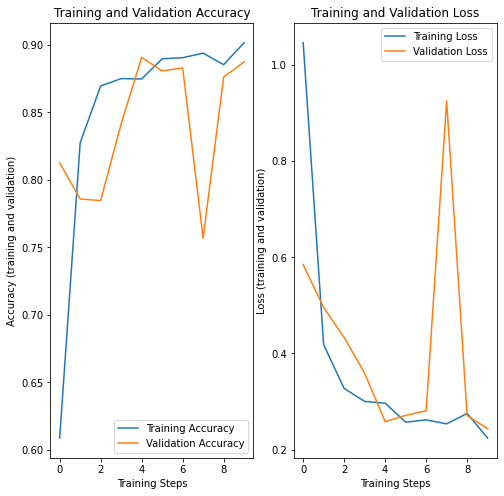

In [12]:
#plot accuracy dan loss pada data latih dan data validasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")

plt.show()

In [13]:
#fungsi load image
def load_image(filename):
    img = cv2.imread(os.path.join(validation_dir, filename))
    img = cv2.resize(img, (image_size[0], image_size[1]) )
    img = img /255
    
    return img

#fungsi predict image dari model yang dibangun
def predict_image(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Corn___Northern_Leaf_Blight, file: Corn___Northern_Leaf_Blight/image (910).JPG
PREDICTED: class: Corn____Northern_Leaf_Blight, confidence: 0.363493


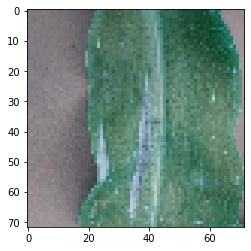

<Figure size 432x288 with 0 Axes>

SOURCE: class: Corn___Common_rust, file: Corn___Common_rust/image (1184).JPG
PREDICTED: class: Corn____Common_rust_, confidence: 1.000000


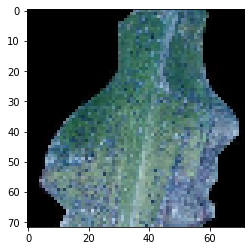

SOURCE: class: Corn___Northern_Leaf_Blight, file: Corn___Northern_Leaf_Blight/image (856).jpg
PREDICTED: class: Corn____Cercospora_leaf_spot Gray_leaf_spot, confidence: 0.651117


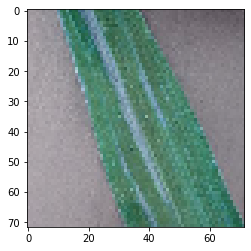

<Figure size 432x288 with 0 Axes>

SOURCE: class: Corn___Cercospora_leaf_spot Gray_leaf_spot, file: Corn___Cercospora_leaf_spot Gray_leaf_spot/image (510).JPG
PREDICTED: class: Background_without_leaves, confidence: 0.997412


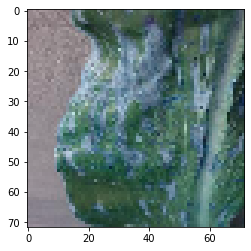

<Figure size 432x288 with 0 Axes>

SOURCE: class: Corn___healthy, file: Corn___healthy/image (995).jpg
PREDICTED: class: Corn____healthy, confidence: 0.999811


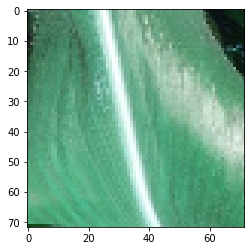

<Figure size 432x288 with 0 Axes>

In [20]:
#prediksi n-gambar secara random
n = 5
for idx, filename in enumerate(random.sample(validation_generator.filenames, n)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_image(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [15]:
#waktu akhir proses eksekusi
end = time.time()

In [16]:
#lama proses eksekusi
print("Lama eksekusi: ", end-start, "s")

Lama eksekusi:  307.61802554130554 s
